In [1]:
import numpy as np
import math
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from fast_dynamics import robot_dynamics_func

In [73]:


robot_state = (1, 2, math.radians(45), 0, 0, 0)
target_state = (0,0,0,0,0,0)

robot_dynamics = robot_dynamics_func()

max_steps = 100

horizon = 20
N = horizon 
dt = 0.1 
Q = np.diag([1, 1, 1, 1, 1, 1]) 
R = 10*np.diag([0.1, 0.1, 0.1]) 


x0 = np.array(robot_state)
xd = np.array(target_state)

In [74]:
def cost_function(u, x, xd):
  cost = 0
  x_pred = np.zeros((N+1, len(xd)))
  x_pred[0,:] = x
  for i in range(N):
    x_pred[i+1,:] = x_pred[i,:] + dt*robot_dynamics(x_pred[i,:], u[i*len(R):(i+1)*len(R)])
    cost += (x_pred[i+1,:] - xd).T @ Q @ (x_pred[i+1,:] - xd) + u[i*len(R):(i+1)*len(R)].T @ R @ u[i*len(R):(i+1)*len(R)]
  return cost


def mpc_solver(x, xd, u0):
  #u0 = np.random.uniform(-5, 5, size=N*len(R))
  bounds = [(-5, 5) for _ in range(N*len(R))]
  result = minimize(cost_function, u0, args=(x, xd), bounds=bounds)
  u_opt = result.x

  return u_opt


In [75]:
np.random.uniform(-5, 5, size=N*len(R))

array([ 2.88260533,  4.15528724, -2.42444605,  0.32679152,  3.72737125,
       -3.73615251,  2.08508668,  1.63604078, -3.4386136 ,  1.48212881,
       -0.02894638,  0.9780483 ,  2.52949577, -0.35573958, -1.57030174,
       -2.62083761,  3.80267156, -3.34722012, -3.50011147,  1.12676364,
       -3.31051989, -1.66725312, -2.28629682,  3.69720325, -4.47356719,
       -1.27964587,  1.21908872,  1.50275861,  4.55941779, -4.62394893,
       -3.04988677,  0.92412741, -3.42449044,  0.91229203,  3.88779597,
       -4.88184814,  0.08723675,  3.47099944, -4.96517434, -2.1008095 ,
        2.94117529, -3.68899358, -0.18509291,  1.00787536, -1.97081946,
        3.50382729,  2.31743551, -4.12819701, -1.77745477,  2.29013204,
       -1.37893761, -2.66113206,  1.12501836,  0.13561599, -4.68429832,
       -3.9144674 , -2.45190266,  2.70319058,  0.37298017,  3.06710258])

In [ ]:
x = x0
x_history = [x0]
u_history = []
u0 = np.zeros(N*len(R))
for i in range(max_steps):
  u_opt = mpc_solver(x, xd, u0)

  u = u_opt[:len(R)]
  u_history.append(u)
  u0 = u_opt.copy()

  x_dot = robot_dynamics(x, u)
  x = x + dt*x_dot
  x_history.append(x)
  print(f'Step {i+1} completed out of {max_steps}...')

Step 1 completed out of 100...


In [71]:
t_vals = np.arange(0, (len(x_history)-1)*dt, dt)
x_history = np.array(x_history)
u_history = np.array(u_history)

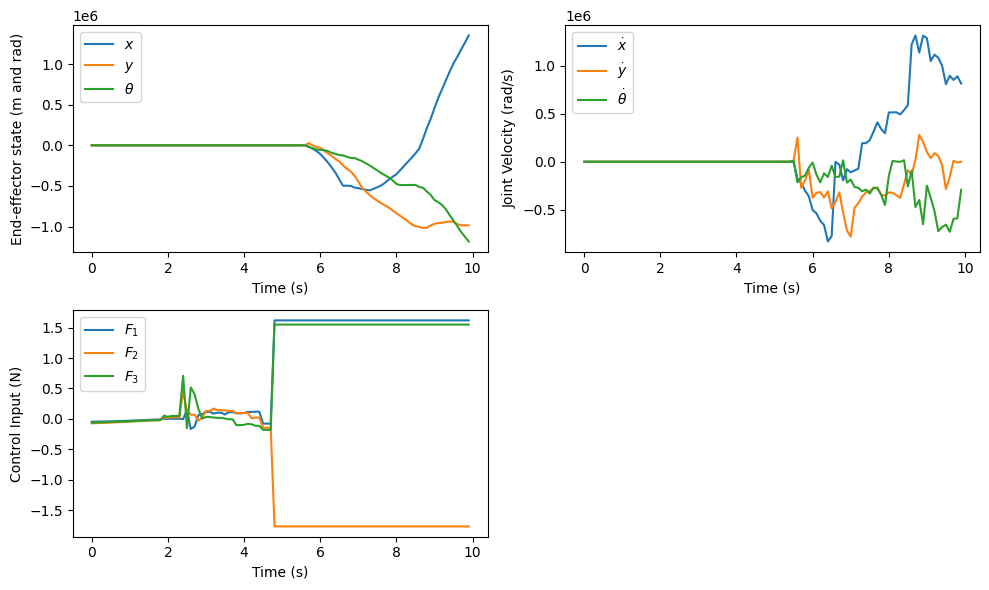

In [72]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(t_vals, x_history[:-1, 0], label=r"$x$")
plt.plot(t_vals, x_history[:-1, 1], label=r"$y$")
plt.plot(t_vals, x_history[:-1, 2], label=r"$\theta$")
plt.xlabel("Time (s)")
plt.ylabel("End-effector state (m and rad)")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(t_vals, x_history[:-1, 3], label=r"$\dot{x}$")
plt.plot(t_vals, x_history[:-1, 4], label=r"$\dot{y}$")
plt.plot(t_vals, x_history[:-1, 5], label=r"$\dot{\theta}$")
plt.xlabel("Time (s)")
plt.ylabel("Joint Velocity (rad/s)")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(t_vals, u_history[:, 0], label=r"$F_1$")
plt.plot(t_vals, u_history[:, 1], label=r"$F_2$")
plt.plot(t_vals, u_history[:, 2], label=r"$F_3$")
plt.xlabel("Time (s)")
plt.ylabel("Control Input (N)")
plt.legend()

plt.tight_layout()
plt.savefig(f'result.png', bbox_inches='tight', transparent=True, dpi=1200)
plt.show()